In [3]:
import pandas as pd
# baic transformer Decoder model
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torch.optim as optim
import numpy as np
import xformers.ops as xops
import math
from typing import Optional, Union
from torch import Tensor
import random

main_df = pd.read_csv('adult.csv')
main_df.head()
DEVICE = 'cuda'
# DEVICE = 'cpu'

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
def POOL_preprocess(df, N_BINS = 100):
    
    CAT = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
    NUM = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
    
    num_CAT = len(CAT)
    num_NUM = len(NUM)  
    
    ct = ColumnTransformer([
        ("age", KBinsDiscretizer(n_bins = N_BINS, encode='ordinal', strategy='uniform', subsample=None), ["age"]),
        ("fnlwgt", KBinsDiscretizer(n_bins = N_BINS, encode='ordinal', strategy='quantile', subsample=None), ["fnlwgt"]),
        ("educational-num", KBinsDiscretizer(n_bins = N_BINS, encode='ordinal', strategy='quantile', subsample=None), ["educational-num"]),
        ("capital-gain", KBinsDiscretizer(n_bins = N_BINS, encode='ordinal', strategy='uniform', subsample=None), ["capital-gain"]),
        ("capital-loss", KBinsDiscretizer(n_bins = N_BINS, encode='ordinal', strategy='uniform', subsample=None), ["capital-loss"]),
        ("hours-per-week", KBinsDiscretizer(n_bins = N_BINS, encode='ordinal', strategy='uniform', subsample=None), ["hours-per-week"]),
         ],remainder = 'passthrough', verbose_feature_names_out = False) # make sure columns are unique
    ct.set_output(transform = 'pandas')
    X_trans = ct.fit_transform(df) 
    
    # make catagoy in NUM columns unique
    # each NUM column has N_BINS unique values, that is, each NUM column represents as N_BINS node
    # 7/19: each NUM column has its own number of unique values, plus 1 for unseen values
    offset = 0
    # for column in NUM:
    #     X_trans[column] = X_trans[column].apply(lambda x: x + offset)
    #     # offset += N_BINS
    #     offset += X_trans[column].nunique() + 1
    
    # apply lable encoding on CAT columns
    from sklearn.preprocessing import LabelEncoder
    lb = LabelEncoder()
    X_trans[NUM] = X_trans[NUM].apply(lambda x: lb.fit_transform(x))
    X_trans[CAT] = X_trans[CAT].apply(lambda x: lb.fit_transform(x))
    
    # make catagoy all columns unique
    # each column has it's own number of unique values. '+1' is for unseen values
    # offset = len(NUM) * N_BINS
    for column in NUM + CAT:
        X_trans[column] = X_trans[column].apply(lambda x: x + offset)
        offset += (X_trans[column].max() - X_trans[column].min() + 1) + 1
    
    X_trans = X_trans.astype(int).reset_index(drop = True)
    return X_trans, ct, (num_NUM, num_CAT - 1) # -1 is for the income column (label)
X_trans, _, _= POOL_preprocess(main_df[48842//5:])
X_trans.head()

/home/tsou/.conda/envs/xformers/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
0,16,131,188,191,215,334,367,383,392,400,413,421,425,467,472
1,62,116,178,191,215,279,365,376,390,408,412,423,426,467,471
2,16,168,189,191,215,304,365,381,390,409,412,420,426,452,471
3,19,136,180,191,215,334,365,371,390,410,412,423,426,467,471
4,29,139,187,191,215,304,367,380,390,409,412,423,426,467,472


In [5]:
for column in X_trans.columns:
    print(column, X_trans[column].min(),X_trans[column].max())

age 0 73
fnlwgt 75 174
educational-num 176 189
capital-gain 191 213
capital-loss 215 263
hours-per-week 265 359
workclass 361 369
education 371 386
marital-status 388 394
occupation 396 410
relationship 412 417
race 419 423
gender 425 426
native-country 428 469
income 471 472


In [6]:
train_size = 4*48842//5
test_size = 48842//5
train_pool = main_df[test_size:]
test_pool = main_df[:test_size]
print('total data num:' , main_df.shape[0])
print('trian data num:' , train_pool.shape[0])
print('test data num:' , test_pool.shape[0])

total data num: 48842
trian data num: 39074
test data num: 9768


In [7]:
# notations
#   node: number of all nodes = L + S + C + F
#   L: number of lable nodes
#   S: number of sample nodes
#   C: number of catagory nodes
#   F: number of field(column) nodes
#   hidden: number of hidden representation

# data size = (node, hidden)
# mask size = (node, node - L) without lable nodes
#             for each node, real mask = cat[mask,(node,L)] = (node, node)
#             cannot see it's label node

# use nn.transformerDecoder(data,mask) to get the output
# use the above output as input of MLP to predict the lable   

In [8]:
class HGNN_DataSet():
    def __init__(self,
                 data_df : pd.DataFrame,
                 split_ratio : float ,
                 label_column : str,
                 ):
        # shuffle data
        data_df = data_df.sample(frac=1).reset_index(drop=True)
        test_size = math.ceil(data_df.shape[0] * (1-split_ratio))
        train_pool = data_df[test_size:]
        test_pool = data_df[:test_size]
        print('total data num:' , data_df.shape[0])
        print('trian data num:' , train_pool.shape[0])
        print('test data num:' , test_pool.shape[0])
        
        # to-dos:
        # train
        #   
        N_BINS = 100
        TARGET_POOL, self.CT, self.NUM_vs_CAT = POOL_preprocess(train_pool, N_BINS = N_BINS)
        # TEST_POOL = POOL_preprocess(test_pool)
        LABEL_COLUMN = label_column

        # cut feature and lable
        FEATURE_POOL = TARGET_POOL.drop(LABEL_COLUMN, axis=1)
        LABEL_POOL = TARGET_POOL[LABEL_COLUMN]
        
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder()
        LABEL_POOL = enc.fit_transform(LABEL_POOL.values.reshape(-1,1)).toarray()

        # L: number of lable nodes
        # the last node of Lable nodes is served as unknown lable node
        L = LABEL_POOL.shape[1] + 1

        # S: number of sample nodes
        S = FEATURE_POOL.shape[0] + 1
        # the last node of sample nodes is served as infering node
        
        # F: number of field(column) nodes
        F = FEATURE_POOL.shape[1]

        # C: number of catagory nodes
        # first, caculate nodes of each field, including unseen node
        self.nodes_of_fields = []
        for column in FEATURE_POOL.columns:
            self.nodes_of_fields.append(FEATURE_POOL[column].nunique()+1)
        C = sum(self.nodes_of_fields) # the total number of nodes equals to the sum of nodes of each field
        C_POOL = range(int(C))

        nodes_num = {'L':L, 'S':S, 'C':C, 'F':F}
        print('node_nums', nodes_num)
        print('total', L+S+C+F, 'nodes')
        
        # get samples index for each label
        self.labe_to_index = {}
        tmp_pool = TARGET_POOL.copy().reset_index(drop=True)
        for label in tmp_pool['income'].unique():
            self.labe_to_index[label] = (tmp_pool[tmp_pool['income'] == label].index).tolist()
        
        self.TARGET_POOL = TARGET_POOL
        # self.TEST_POOL = TEST_POOL
        self.LABEL_COLUMN = LABEL_COLUMN
        self.FEATURE_POOL = FEATURE_POOL
        self.LABEL_POOL = LABEL_POOL
        self.C_POOL = C_POOL   
        self.nodes_num = nodes_num
        self.N_BINS = N_BINS

        
        self.make_input_tensor()
        # self.get_sample(10)        
        self.make_mask_all()
        
        # self.make_mask()
        
        
    def make_mask(self,
                  sample_indices: Optional[list] = None,
                ):
        L, S, C, F = self.nodes_num['L'], self.nodes_num['S'], self.nodes_num['C'], self.nodes_num['F']

        sample_size = len(sample_indices)
        masked_POOL = self.TARGET_POOL.iloc[sample_indices]
        # caculate masking
        masks = {}

        # label to sample 
        tmp = torch.zeros([math.ceil(sample_size/8) * 8, math.ceil(L/8) * 8], dtype=torch.float, device=DEVICE)
        label_ids = self.TARGET_POOL[self.LABEL_COLUMN].unique()
        for i, value_df in enumerate(masked_POOL[self.LABEL_COLUMN]):
            for j, value_label in enumerate(label_ids):
                if value_label == value_df:
                    tmp[i][j] = 1
                    break
        masks['L2S'] = Tensor.contiguous(tmp)

        # sample to catagory
        tmp = torch.zeros([math.ceil(C/8) * 8, math.ceil(sample_size/8) * 8], dtype=torch.float, device=DEVICE).T
        tmp_df = masked_POOL.drop(self.LABEL_COLUMN, axis=1)
        tmp[torch.arange(sample_size).unsqueeze(-1), torch.tensor(tmp_df.values)] = 1
        tmp = tmp.T.contiguous()
        
        # tmp = (S, C)
        # df = (S, col) 
        #
        # [
        #   [10, 20, 25, ...]
        #   [10, 20, 25, ...]
        # ]
        
        # indexes = [....]
        # CC[indexes] = 1
        
        # tmp[torch.arange(S).unsqueeze(-1), torch.tensor(df.values)] = 1
        
                
        masks['S2C'] = Tensor.contiguous(tmp)

        # catagory to field
        masks['C2F'] = self.MASKS_FULL['C2F']
        
        self.MASKS = masks
        self.nodes_num['K'] = sample_size
        
    def make_mask_all(self,
                  sample_indices: Optional[torch.tensor] = None,
                ):
        L, S, C, F = self.nodes_num['L'], self.nodes_num['S'], self.nodes_num['C'], self.nodes_num['F']
        # caculate masking
        masks = {}
        
        # label to sample 
        tmp = torch.zeros([math.ceil(S/8) * 8, math.ceil(L/8) * 8], dtype=torch.float, device=DEVICE)
        label_ids = self.TARGET_POOL[self.LABEL_COLUMN].unique()
        for i, value_df in enumerate(self.TARGET_POOL[self.LABEL_COLUMN]):
            for j, value_label in enumerate(label_ids):
                if value_label == value_df:
                    tmp[i][j] = 1
                    break
        masks['L2S'] = tmp

        # sample to catagory
        tmp = torch.zeros([math.ceil(C/8) * 8, math.ceil(S/8) * 8], dtype=torch.float, device=DEVICE).T
        tmp_df = self.TARGET_POOL.drop(self.LABEL_COLUMN, axis=1)
        # for i, value_df in enumerate(tmp_df.values):
        #     for j, value in enumerate(value_df):
        #         tmp[value][i] = 1
        tmp[torch.arange(len(self.TARGET_POOL)).unsqueeze(-1), torch.tensor(tmp_df.values)] = 1
        tmp = tmp.T.contiguous()
        masks['S2C'] = tmp

        # catagory to field
        tmp = torch.zeros([math.ceil(F/8) * 8, math.ceil(C/8) * 8], dtype=torch.float, device=DEVICE)
        unique_items = [sorted(self.FEATURE_POOL[column].unique()) for column in (self.FEATURE_POOL.columns)]
        for i in range(F):
            for j in (unique_items[i]):
                tmp[i][j] = 1
        masks['C2F'] = tmp
        
        
        self.MASKS = masks
        self.MASKS_FULL = masks

    
    def make_input_tensor(self):
        # make input tensor
        L, S, C, F = self.nodes_num['L'], self.nodes_num['S'], self.nodes_num['C'], self.nodes_num['F']
        # L
        L_input = torch.tensor([range(L)], device=DEVICE).reshape(-1,1)
        print('L_input', L_input.type(), L_input.shape)
        
        # S (normalized by standard scaler)
        # features = torch.tensor(self.FEATURE_POOL.values, device=DEVICE).float()
        # normalized_features = (features - torch.mean(features, dim = 0)) / torch.std(features, dim = 0)
        # S_input = torch.cat([normalized_features, torch.tensor([[0]*F], device=DEVICE)],dim = 0).float() # add infering node
        
        # S (initialize by random)
        S_input = torch.rand(128, device=DEVICE).repeat(S,1)
        
        print('S_input', S_input.type(), S_input.shape)
        # C 
        C_input = torch.tensor([self.C_POOL], device=DEVICE).reshape(-1,1)
        print('C_input', C_input.type(), C_input.shape)
        # F 
        F_input = torch.tensor([range(F)], device=DEVICE).reshape(-1,1)
        print('F_input', F_input.type(), F_input.shape)
        # 
        self.INPUTS = (L_input, S_input, C_input, F_input)
        self.INPUT_DIMS = (L_input.size(1), S_input.size(1), C_input.size(1), F_input.size(1))
        
    def sample_with_distrubution(self, sample_size):
        # sample with distrubution
        """
        currently, only support binary label
        forced to make balenced sample
        """
        
        # decide each label's number of samples (fourced to be balenced if possible) 
        label_list = []
        label_unique = list(self.labe_to_index.keys())
        count = sample_size // len(label_unique)
        remainder = sample_size % len(label_unique)
        label_list = [item for item in label_unique for _ in range(count)]
        label_list.extend(random.sample(label_unique, remainder))
        # sample from indexes
        indices = [random.choice(self.labe_to_index[label]) for label in label_list]
        return indices     
        
    def get_sample(self, sample_size, inculde = []):
        # get K samples from S
        # return sample node indices
        
        # inculde specific nodes (e.g. query nodes), while remaining sample_size
        sample_indices = self.sample_with_distrubution(sample_size - len(inculde))
        if inculde is not []:
            while inculde in sample_indices:
                sample_indices = self.sample_with_distrubution(sample_size - len(inculde))
            # add inculde nodes into sample_indices
            for node in inculde:
                sample_indices.append(node)
            sample_indices = sorted(sample_indices)
        # 作傻事
        # sample_indices = [random.choice(Train_data.labe_to_index[472]) for i in range(sample_size-1)]
        # sample_indices.append(inculde[0])
        # update mask
        sample_indices = sorted(sample_indices)
        self.make_mask(sample_indices)
        
        # modify input tensor
        L_input, S_input, C_input, F_input = self.INPUTS
        S_input_masked = torch.index_select(S_input, 0, torch.tensor(sample_indices, device=DEVICE))
        self.MASKED_INPUTS = (L_input, S_input_masked, C_input, F_input) 
          
        return sample_indices
            
Train_data = HGNN_DataSet( main_df, 0.8, 'income')
Train_data.get_sample(10)


total data num: 48842
trian data num: 39073
test data num: 9769


/home/tsou/.conda/envs/xformers/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


node_nums {'L': 3, 'S': 39074, 'C': 469, 'F': 14}
total 39560 nodes
L_input torch.cuda.LongTensor torch.Size([3, 1])
S_input torch.cuda.FloatTensor torch.Size([39074, 128])
C_input torch.cuda.LongTensor torch.Size([469, 1])
F_input torch.cuda.LongTensor torch.Size([14, 1])


[3558, 5987, 6988, 12988, 13657, 16096, 18399, 23675, 30662, 30991]

In [9]:
Train_data.INPUTS[0]

tensor([[0],
        [1],
        [2]], device='cuda:0')

In [10]:
Train_data.INPUTS[1]

tensor([[0.9337, 0.3869, 0.0326,  ..., 0.0852, 0.7448, 0.8449],
        [0.9337, 0.3869, 0.0326,  ..., 0.0852, 0.7448, 0.8449],
        [0.9337, 0.3869, 0.0326,  ..., 0.0852, 0.7448, 0.8449],
        ...,
        [0.9337, 0.3869, 0.0326,  ..., 0.0852, 0.7448, 0.8449],
        [0.9337, 0.3869, 0.0326,  ..., 0.0852, 0.7448, 0.8449],
        [0.9337, 0.3869, 0.0326,  ..., 0.0852, 0.7448, 0.8449]],
       device='cuda:0')

In [11]:
# Train_data.get_sample(100, inculde=[10])


In [12]:
from torch import Tensor
from typing import Optional, Any, Union, Callable

class CustomTransformerDecoderLayer(nn.TransformerDecoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation='relu'):
        super().__init__(d_model, nhead, dim_feedforward, dropout, activation)
        # remove defined modules
        delattr(self, 'self_attn')
        delattr(self, 'norm1')
        delattr(self, 'dropout1')
    
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        x = tgt
        # x = self.norm1(x + self._sa_block(x, tgt_mask, tgt_key_padding_mask))
        x = self.norm2(x + self._mha_block(x, memory, memory_mask))
        # x =  x + self._mha_block(x, memory, memory_mask, memory_key_padding_mask)
        # x = self.norm3(x + self._ff_block(x))

        return x
    def _mha_block(self, x: Tensor, mem: Tensor,
                   attn_mask: Optional[Tensor],) -> Tensor:
        x = xops.memory_efficient_attention(x, mem, mem, attn_mask)
        # return self.dropout2(x)
        return (x)


In [13]:
# baic transformer decoder model
import torch
import torch.nn as nn
import torch.nn.functional as Fun
from tqdm import trange

class TransformerDecoderModel(nn.Module):
    def __init__(self, 
                 target_dataset, 
                 num_layers, 
                 embedding_dim,  
                 subgraph_masked: Optional[bool] = False,
                 K : Optional[int] = 10,
                 ):
        super(TransformerDecoderModel, self).__init__()

        L_dim, S_dim, C_dim, F_dim = target_dataset.INPUT_DIMS
        L, S, C, F = target_dataset.nodes_num['L'], target_dataset.nodes_num['S'], target_dataset.nodes_num['C'], target_dataset.nodes_num['F']
        num_NUM , num_CAT = target_dataset.NUM_vs_CAT
        
        # check input dims
        # if num_CAT + num_NUM != S_dim:
        #     raise ValueError('num_CAT + num_NUM != number of columns (S_dim)   {} + {} != {}'.format(num_CAT, num_NUM, S_dim))
        
        # 目前b卡在embedding的怎麼用
        # Catagory_embedding => 數值類Qcut後用linear來做embedding, 類別用nn.Embedding

        
        # nn.Embedding( number of possible catagories, embedding_dim, )
        # nn.Linear( number of input dimantion, embedding_dim, )

        self.Lable_embedding = nn.Embedding(L, embedding_dim, dtype=torch.float)
        
        # self.Sample_embedding_num = nn.Linear(num_NUM, embedding_dim, dtype=torch.float)
        # # use MLP projector to project sample feature from 8 dim to 128 dim
        # # self.Sample_embedding_cat = nn.Linear(num_CAT, embedding_dim, dtype=torch.float)
        # self.Sample_embedding_cat = nn.Sequential(
        #                                 nn.Linear(num_CAT, 64),  
        #                                 nn.ReLU(),        
        #                                 nn.Linear(64, embedding_dim) 
        #                             )
                                    
        
        # self.Catagory_embedding_num = nn.Linear(C_dim, embedding_dim, dtype=torch.float)
        # for every numrical filed, construct it's own Linear embedding layer
        self.Catagory_embedding_nums = []
        for i in range(num_NUM):
            self.Catagory_embedding_nums.append(
                nn.Linear(C_dim, embedding_dim, dtype=torch.float, device=DEVICE)
            )
        catagories = target_dataset.nodes_of_fields[-num_CAT:] # number of all possible catagories nodes
        self.Catagory_embedding_cat = nn.Embedding(sum(catagories), embedding_dim, dtype=torch.float)
        
        self.Field_embedding = nn.Embedding(F, embedding_dim, dtype=torch.float)
        
        self.transformer_decoder = nn.TransformerDecoder(
            CustomTransformerDecoderLayer(embedding_dim,  nhead = 2 ),
            num_layers
        )
        
        # downstream task
        self.MLP = nn.Sequential(
            nn.Linear(embedding_dim, 2),
        )
        
        self.subgraph_masked = subgraph_masked
        if subgraph_masked: 
            self.K = K
            target_dataset.get_sample(self.K)
        else:
            # init mask
            target_dataset.make_mask_all()
        
        self.tmpmask_L2S = target_dataset.MASKS['L2S'].clone()


    def forward(self, 
                target_dataset: HGNN_DataSet, 
                ):
        L, S, C, F = target_dataset.nodes_num['L'], target_dataset.nodes_num['S'], target_dataset.nodes_num['C'], target_dataset.nodes_num['F']
        num_NUM, num_CAT = target_dataset.NUM_vs_CAT
        
        if self.subgraph_masked: 
            # sample K nodes from S to construct subgraph
            # target_dataset.get_sample(self.K)  ==> do not do this again!!! for every query, only one "get_sample" is needed
            L_input, S_input, C_input, F_input = target_dataset.MASKED_INPUTS
            masks = target_dataset.MASKS
            # K = target_dataset.nodes_num['K'] 
            S_ = self.K
        else:
            # to-do: this could make model slow
            target_dataset.make_input_tensor()
            L_input, S_input, C_input, F_input = target_dataset.INPUTS
            target_dataset.make_mask_all()
            masks = target_dataset.MASKS
            S_ = S

        # for S and C, we use two different embedding methods, for CAT and NUM, respectively
        # Squeeze for making batch dimantion
        L_embedded = self.Lable_embedding(L_input.long()).squeeze(1).unsqueeze(0).float()
        
        S_embedded = S_input.unsqueeze(0).float()



        # for every numrical filed, use it's own Linear embedding layer
        C_embedded_nums = []
        field = target_dataset.nodes_of_fields
        start = 0
        for index, nodes in enumerate(field[:num_NUM]): # pick numrical fields
            end = start + nodes
            C_embedded_nums.append(self.Catagory_embedding_nums[index](C_input[start:end].float()).unsqueeze(0))
            start = end
        C_embedded_num = torch.cat(C_embedded_nums, dim = 1)
        
        catagorical_filed_nodes = sum(field[-num_CAT:]) # pick catagory fields
        C_embedded_cat = self.Catagory_embedding_cat(C_input[-catagorical_filed_nodes:].squeeze(1).long() - sum(field[:num_NUM])).unsqueeze(0).float() # - sum(field[:num_NUM] because the embedding index should start from 0
        C_embedded = torch.cat([C_embedded_num, C_embedded_cat], dim = 1)
        
        F_embedded = self.Field_embedding(F_input.long()).squeeze(1).unsqueeze(0).float()
        
        # print(L_embedded.shape, S_embedded.shape, C_embedded.shape, F_embedded.shape)
        
        
        # propagate steps: L→S→C→F
        #                  L←S←C←
        # more steps more menory usage
        PROPAGATE_STEPS = 1
        for i in range(PROPAGATE_STEPS):
            S_embedded = self.transformer_decoder(S_embedded,L_embedded, 
                                                memory_mask = self.tmpmask_L2S[:S_,:L]) 
            C_embedded = self.transformer_decoder(C_embedded,S_embedded,
                                                memory_mask = masks['S2C'][:C,:S_])
            F_embedded = self.transformer_decoder(F_embedded,C_embedded,
                                                memory_mask = masks['C2F'][:F,:C])
            C_embedded = self.transformer_decoder(C_embedded,F_embedded,
                                                memory_mask = Tensor.contiguous(masks['C2F'].transpose(0, 1))[:C,:F])
            S_embedded = self.transformer_decoder(S_embedded,C_embedded,
                                                memory_mask = Tensor.contiguous(masks['S2C'].transpose(0, 1))[:S_,:C])
            L_embedded = self.transformer_decoder(L_embedded,S_embedded, 
                                                memory_mask = Tensor.contiguous(self.tmpmask_L2S.transpose(0, 1))[:L,:S_])
        
        # print('after',S_embedded[0][0])
        output = self.MLP(S_embedded)[0]
        return output

# 測試模型
num_layers = 1  # TransformerDecoder 的層數
embedding_dim = 128  # 嵌入維度
hidden_dim = 64  

print('input_dims', Train_data.INPUT_DIMS)
model = TransformerDecoderModel(Train_data, num_layers, embedding_dim, subgraph_masked = True, K = 4).to(DEVICE)

model.tmpmask_L2S = Train_data.MASKS['L2S'].clone().detach()
model.tmpmask_L2S[0] = 0
model.tmpmask_L2S[0][3-1] = 1 # make it as unseen label
print(Train_data.MASKS['L2S'][:4,:3])
print(model.tmpmask_L2S[:4,:3])

outputs = model(Train_data)
print("模型輸出的大小:", outputs.shape)
print(outputs)
output_label = torch.argmax(outputs.softmax(dim=0), dim=1)
output_label



input_dims (1, 128, 1, 1)
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], device='cuda:0')
tensor([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], device='cuda:0')
模型輸出的大小: torch.Size([4, 2])
tensor([[0.1315, 0.4751],
        [0.1654, 0.2339],
        [0.2044, 0.5912],
        [0.2001, 0.5755]], device='cuda:0', grad_fn=<SelectBackward0>)


tensor([1, 0, 1, 1], device='cuda:0')

In [14]:
label = torch.tensor([1,2,3])
mask = torch.tensor([[1,0,0],
                     [1,0,0],
                     [0,1,0],
                     [1,0,0],
                     [0,1,0],])
sample = torch.tensor([10,20,30,40,50])

selected_labels = torch.zeros(mask.size(0), dtype=label.dtype)
for i in range(mask.size(0)):
    selected_labels[i] = label[mask[i].nonzero(as_tuple=True)]

selected_labels * sample + sample

tensor([ 20,  40,  90,  80, 150])

In [15]:
Train_data.TARGET_POOL.iloc[3].income

469

In [18]:
# training
from torch import autograd
from torcheval.metrics.aggregation.auc import AUC
from torcheval.metrics import BinaryAUROC
from sklearn.metrics import roc_auc_score
tmp_log = []
tmp__log = []
def train(model, datset):
    LABEL_POOL = datset.LABEL_POOL
    weight=torch.from_numpy(np.array([0.2, 1])).float().to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 200
    for epoch in range(epochs):
        
        # train
        model.train()
        # logs
        loss_log = []
        AUC_metric = BinaryAUROC().to(DEVICE)
        
        iter = 0
        for index in trange(len(datset.FEATURE_POOL)): # query through all sample nodes (not infering node)
            # for all query, input = sample K + 1 query smaple
            sample_indices = datset.get_sample(model.K, inculde = [index])
            
            # modify the mask to mask out the queries node's edge to it's label node
            L = datset.nodes_num['L']
            query_index = sample_indices.index(index) # query_index: index of query node in sample_indices
            model.tmpmask_L2S = datset.MASKS['L2S'].clone().detach()
            model.tmpmask_L2S[query_index] = 0
            model.tmpmask_L2S[query_index][L-1] = 1 # make it as unseen label

            
            optimizer.zero_grad()
            outputs = model(datset)
            
                
            outputs = outputs[query_index]
            # for trainning, only the query node's output is used
            # caculate loss
            if model.subgraph_masked:
                # get the real label fo query node
                LABEL_POOL_ = LABEL_POOL[index]
            else:
                LABEL_POOL_ = LABEL_POOL
            
            # print((LABEL_POOL_),Train_data.TARGET_POOL.iloc[index].income - 471)
            # caculate loss
            batch_loss = criterion(outputs, torch.tensor(LABEL_POOL_,device=DEVICE))
            loss_log.append(batch_loss.item())
            
            # backpropagation
            batch_loss.backward()
            optimizer.step()

            TRUE = (torch.argmax(torch.tensor(LABEL_POOL_,device=DEVICE)))
            
            outputs = outputs.softmax(dim=0)
            pred_prob_of_is_1 = outputs[1] # the probability of the query node is 1 (from model output)
            
            
            # tmp_log.append(float(pred_prob_of_is_1))
            # tmp__log.append((TRUE))
            
            AUC_metric.update(torch.Tensor([pred_prob_of_is_1]),torch.Tensor([TRUE]))
            torch.cuda.empty_cache()
            
            iter += 1
            if iter >= 100:
                break
        # print('1 rate pre:',sum(tmp_log)/len(tmp_log),len(tmp_log))
        # print('1 rate tru:',float(sum(tmp__log)/len(tmp__log)),len(tmp__log))
        # print(tmp__log)
        # print(TRUE)
        # print(float(AUC_metric.compute()))
        # AUC_metric.reset()
        # AUC_metric.update(torch.Tensor(tmp_log),torch.Tensor(tmp__log))
        # print(float(AUC_metric.compute()))
        
        

        epoch_loss = sum(loss_log) / len(loss_log)
        epoch_AUC = float(AUC_metric.compute()) 

        AUC_metric.reset()
        # break
        del loss_log, AUC_metric
        tmp_log.append(float(epoch_loss))
        tmp__log.append(float(epoch_AUC))
        
        print(f"Epoch{epoch+1}/{epochs} | Loss: {epoch_loss} | AUC: {epoch_AUC}")
        
        
        with open('logs/log.txt', 'a') as f:
            f.write(f"Epoch{epoch+1}/{epochs} | Loss: {epoch_loss} | AUC: {epoch_AUC}\n")

model = TransformerDecoderModel(Train_data, num_layers, embedding_dim, subgraph_masked = True, K = 200).to(DEVICE)
train(model, Train_data)

  0%|          | 0/39073 [00:00<?, ?it/s]

  0%|          | 99/39073 [00:00<04:13, 153.50it/s]


Epoch1/200 | Loss: 0.28683856694446436 | AUC: 0.5248


  0%|          | 99/39073 [00:00<04:14, 152.89it/s]


Epoch2/200 | Loss: 0.29349579961227923 | AUC: 0.4789333333333333


  0%|          | 99/39073 [00:00<04:13, 153.74it/s]


Epoch3/200 | Loss: 0.2919294123704047 | AUC: 0.48213333333333336


  0%|          | 99/39073 [00:00<04:16, 151.83it/s]


Epoch4/200 | Loss: 0.29096007746775676 | AUC: 0.47946666666666665


  0%|          | 99/39073 [00:00<04:12, 154.46it/s]


Epoch5/200 | Loss: 0.2900575534691795 | AUC: 0.48533333333333334


  0%|          | 99/39073 [00:00<04:12, 154.35it/s]


Epoch6/200 | Loss: 0.28924141981643936 | AUC: 0.4826666666666667


  0%|          | 99/39073 [00:00<04:11, 155.19it/s]


Epoch7/200 | Loss: 0.28847795026465817 | AUC: 0.4848


  0%|          | 99/39073 [00:00<04:10, 155.30it/s]


Epoch8/200 | Loss: 0.28776142783500164 | AUC: 0.48533333333333334


  0%|          | 99/39073 [00:00<04:11, 155.09it/s]


Epoch9/200 | Loss: 0.2870583297120006 | AUC: 0.4864


  0%|          | 99/39073 [00:00<04:11, 154.73it/s]


Epoch10/200 | Loss: 0.28639797562979286 | AUC: 0.48693333333333333


  0%|          | 99/39073 [00:00<04:11, 155.15it/s]


Epoch11/200 | Loss: 0.28576090812873334 | AUC: 0.488


  0%|          | 99/39073 [00:00<04:11, 155.08it/s]


Epoch12/200 | Loss: 0.2851114653027429 | AUC: 0.488


  0%|          | 99/39073 [00:00<04:11, 154.91it/s]


Epoch13/200 | Loss: 0.28443904378295226 | AUC: 0.4885333333333333


  0%|          | 99/39073 [00:00<04:11, 154.98it/s]


Epoch14/200 | Loss: 0.28373539816145465 | AUC: 0.49066666666666664


  0%|          | 99/39073 [00:00<04:10, 155.48it/s]


Epoch15/200 | Loss: 0.28297354228541244 | AUC: 0.4912


  0%|          | 99/39073 [00:00<04:11, 155.10it/s]


Epoch16/200 | Loss: 0.2821405607230825 | AUC: 0.49173333333333336


  0%|          | 99/39073 [00:00<04:10, 155.37it/s]


Epoch17/200 | Loss: 0.281143322139789 | AUC: 0.4997333333333333


  0%|          | 99/39073 [00:00<04:12, 154.59it/s]


Epoch18/200 | Loss: 0.2799079241071466 | AUC: 0.5082666666666666


  0%|          | 99/39073 [00:00<04:11, 154.96it/s]


Epoch19/200 | Loss: 0.27830691034649757 | AUC: 0.5168


  0%|          | 99/39073 [00:00<04:12, 154.10it/s]


Epoch20/200 | Loss: 0.27613922613356245 | AUC: 0.5306666666666666


  0%|          | 99/39073 [00:00<04:11, 154.91it/s]


Epoch21/200 | Loss: 0.2731367764505186 | AUC: 0.5493333333333333


  0%|          | 99/39073 [00:00<04:12, 154.65it/s]


Epoch22/200 | Loss: 0.26896071583231435 | AUC: 0.5754666666666667


  0%|          | 99/39073 [00:00<04:12, 154.12it/s]


Epoch23/200 | Loss: 0.2636894523695162 | AUC: 0.6048


  0%|          | 99/39073 [00:00<04:12, 154.22it/s]


Epoch24/200 | Loss: 0.25742776873392154 | AUC: 0.6282666666666666


  0%|          | 99/39073 [00:00<04:10, 155.44it/s]


Epoch25/200 | Loss: 0.2507428414968493 | AUC: 0.656


  0%|          | 99/39073 [00:00<04:12, 154.53it/s]


Epoch26/200 | Loss: 0.24427942997719693 | AUC: 0.6757333333333333


  0%|          | 99/39073 [00:00<04:10, 155.58it/s]


Epoch27/200 | Loss: 0.2389157927685116 | AUC: 0.696


  0%|          | 99/39073 [00:00<04:12, 154.64it/s]


Epoch28/200 | Loss: 0.23518887339876668 | AUC: 0.7178666666666667


  0%|          | 99/39073 [00:00<04:11, 155.00it/s]


Epoch29/200 | Loss: 0.23263197098907726 | AUC: 0.7333333333333333


  0%|          | 99/39073 [00:00<04:11, 155.01it/s]


Epoch30/200 | Loss: 0.23158255641743913 | AUC: 0.7445333333333334


  0%|          | 99/39073 [00:00<04:11, 155.12it/s]


Epoch31/200 | Loss: 0.23000230870732355 | AUC: 0.7482666666666666


  0%|          | 99/39073 [00:00<04:11, 155.18it/s]


Epoch32/200 | Loss: 0.2286991601818333 | AUC: 0.7514666666666666


  0%|          | 99/39073 [00:00<04:13, 153.83it/s]


Epoch33/200 | Loss: 0.22799840142729116 | AUC: 0.7536


  0%|          | 99/39073 [00:00<04:12, 154.29it/s]


Epoch34/200 | Loss: 0.22688818104576822 | AUC: 0.7552


  0%|          | 99/39073 [00:00<04:11, 154.91it/s]


Epoch35/200 | Loss: 0.22608810481410513 | AUC: 0.752


  0%|          | 99/39073 [00:00<04:13, 153.57it/s]


Epoch36/200 | Loss: 0.2249289128541303 | AUC: 0.7578666666666667


  0%|          | 99/39073 [00:00<04:10, 155.48it/s]


Epoch37/200 | Loss: 0.22482109662950855 | AUC: 0.7552


  0%|          | 99/39073 [00:00<04:11, 154.77it/s]


Epoch38/200 | Loss: 0.22355513744756805 | AUC: 0.7589333333333333


  0%|          | 99/39073 [00:00<04:11, 155.25it/s]


Epoch39/200 | Loss: 0.22291516233246134 | AUC: 0.7594666666666666


  0%|          | 99/39073 [00:00<04:11, 154.76it/s]


Epoch40/200 | Loss: 0.22245786409490959 | AUC: 0.7610666666666667


  0%|          | 99/39073 [00:00<04:10, 155.32it/s]


Epoch41/200 | Loss: 0.22154759016188097 | AUC: 0.7626666666666667


  0%|          | 99/39073 [00:00<04:13, 153.91it/s]


Epoch42/200 | Loss: 0.22077012880715097 | AUC: 0.7653333333333333


  0%|          | 99/39073 [00:00<04:12, 154.64it/s]


Epoch43/200 | Loss: 0.2200330264542053 | AUC: 0.7706666666666667


  0%|          | 99/39073 [00:00<04:10, 155.29it/s]


Epoch44/200 | Loss: 0.2196869806638366 | AUC: 0.7717333333333334


  0%|          | 99/39073 [00:00<04:10, 155.46it/s]


Epoch45/200 | Loss: 0.21879655060194034 | AUC: 0.7744


  0%|          | 99/39073 [00:00<04:20, 149.41it/s]


Epoch46/200 | Loss: 0.21821582780953525 | AUC: 0.7754666666666666


  0%|          | 99/39073 [00:00<04:12, 154.49it/s]


Epoch47/200 | Loss: 0.21775266498083468 | AUC: 0.776


  0%|          | 99/39073 [00:00<04:10, 155.54it/s]


Epoch48/200 | Loss: 0.2165066909221089 | AUC: 0.7802666666666667


  0%|          | 99/39073 [00:00<04:15, 152.69it/s]


Epoch49/200 | Loss: 0.21580638183617404 | AUC: 0.7786666666666666


  0%|          | 99/39073 [00:00<04:10, 155.40it/s]


Epoch50/200 | Loss: 0.21524004492950952 | AUC: 0.7818666666666667


  0%|          | 99/39073 [00:00<04:11, 154.82it/s]


Epoch51/200 | Loss: 0.21414893896688716 | AUC: 0.7856


  0%|          | 99/39073 [00:00<04:13, 153.97it/s]


Epoch52/200 | Loss: 0.2136507592313025 | AUC: 0.7856


  0%|          | 99/39073 [00:00<04:12, 154.19it/s]


Epoch53/200 | Loss: 0.21284312582290923 | AUC: 0.7893333333333333


  0%|          | 99/39073 [00:00<04:14, 153.02it/s]


Epoch54/200 | Loss: 0.21184995829424863 | AUC: 0.7952


  0%|          | 99/39073 [00:00<04:10, 155.55it/s]


Epoch55/200 | Loss: 0.21161295227686366 | AUC: 0.7957333333333333


  0%|          | 99/39073 [00:00<04:11, 155.27it/s]


Epoch56/200 | Loss: 0.21084616654462338 | AUC: 0.7968


  0%|          | 99/39073 [00:00<04:11, 154.95it/s]


Epoch57/200 | Loss: 0.2097880340890335 | AUC: 0.7984


  0%|          | 99/39073 [00:00<04:10, 155.46it/s]


Epoch58/200 | Loss: 0.20903620147965765 | AUC: 0.8


  0%|          | 99/39073 [00:00<04:11, 154.66it/s]


Epoch59/200 | Loss: 0.20821430696789306 | AUC: 0.8005333333333333


  0%|          | 99/39073 [00:00<04:10, 155.44it/s]


Epoch60/200 | Loss: 0.20700468991930218 | AUC: 0.8032


  0%|          | 99/39073 [00:00<04:11, 154.88it/s]


Epoch61/200 | Loss: 0.2066102815097024 | AUC: 0.8021333333333334


  0%|          | 99/39073 [00:00<04:10, 155.78it/s]


Epoch62/200 | Loss: 0.20571557536970822 | AUC: 0.8048


  0%|          | 99/39073 [00:00<04:10, 155.32it/s]


Epoch63/200 | Loss: 0.20507270071722147 | AUC: 0.8069333333333333


  0%|          | 99/39073 [00:00<04:10, 155.29it/s]


Epoch64/200 | Loss: 0.20417434931850373 | AUC: 0.8085333333333333


  0%|          | 99/39073 [00:00<04:11, 155.14it/s]


Epoch65/200 | Loss: 0.20368685031693842 | AUC: 0.8090666666666667


  0%|          | 99/39073 [00:00<04:11, 154.84it/s]


Epoch66/200 | Loss: 0.2024641288796466 | AUC: 0.8122666666666667


  0%|          | 99/39073 [00:00<04:11, 155.19it/s]


Epoch67/200 | Loss: 0.20171181482283498 | AUC: 0.8133333333333334


  0%|          | 99/39073 [00:00<04:11, 155.14it/s]


Epoch68/200 | Loss: 0.20094418910403714 | AUC: 0.8128


  0%|          | 99/39073 [00:00<04:12, 154.14it/s]


Epoch69/200 | Loss: 0.20034800351085721 | AUC: 0.8144


  0%|          | 99/39073 [00:00<04:10, 155.44it/s]


Epoch70/200 | Loss: 0.19888190475778159 | AUC: 0.8202666666666667


  0%|          | 99/39073 [00:00<04:10, 155.29it/s]


Epoch71/200 | Loss: 0.1982125828077742 | AUC: 0.8208


  0%|          | 99/39073 [00:00<04:11, 154.75it/s]


Epoch72/200 | Loss: 0.1974372229454415 | AUC: 0.8229333333333333


  0%|          | 99/39073 [00:00<04:13, 153.76it/s]


Epoch73/200 | Loss: 0.19690337425028262 | AUC: 0.8245333333333333


  0%|          | 99/39073 [00:00<04:13, 154.03it/s]


Epoch74/200 | Loss: 0.19584034243724296 | AUC: 0.8272


  0%|          | 99/39073 [00:00<04:12, 154.25it/s]


Epoch75/200 | Loss: 0.1949257856652315 | AUC: 0.8256


  0%|          | 99/39073 [00:00<04:11, 155.24it/s]


Epoch76/200 | Loss: 0.19447841560927348 | AUC: 0.8266666666666667


  0%|          | 99/39073 [00:00<04:10, 155.45it/s]


Epoch77/200 | Loss: 0.19282488977809856 | AUC: 0.8304


  0%|          | 99/39073 [00:00<04:12, 154.41it/s]


Epoch78/200 | Loss: 0.1926114462219818 | AUC: 0.8325333333333333


  0%|          | 99/39073 [00:00<04:10, 155.42it/s]


Epoch79/200 | Loss: 0.1917529962394931 | AUC: 0.8314666666666667


  0%|          | 99/39073 [00:00<04:14, 152.87it/s]


Epoch80/200 | Loss: 0.19062570352622887 | AUC: 0.8362666666666667


  0%|          | 99/39073 [00:00<04:12, 154.18it/s]


Epoch81/200 | Loss: 0.18978805494759868 | AUC: 0.8352


  0%|          | 99/39073 [00:00<04:12, 154.23it/s]


Epoch82/200 | Loss: 0.18924601127926033 | AUC: 0.8384


  0%|          | 99/39073 [00:00<04:11, 155.06it/s]


Epoch83/200 | Loss: 0.18853630515091005 | AUC: 0.8378666666666666


  0%|          | 99/39073 [00:00<04:13, 153.67it/s]


Epoch84/200 | Loss: 0.1879543179730766 | AUC: 0.8416


  0%|          | 99/39073 [00:00<04:12, 154.38it/s]


Epoch85/200 | Loss: 0.1870133129172911 | AUC: 0.8437333333333333


  0%|          | 99/39073 [00:00<04:11, 155.19it/s]


Epoch86/200 | Loss: 0.18605183486097077 | AUC: 0.8442666666666667


  0%|          | 99/39073 [00:00<04:12, 154.65it/s]


Epoch87/200 | Loss: 0.18540271080045606 | AUC: 0.8453333333333334


  0%|          | 99/39073 [00:00<04:14, 152.99it/s]


Epoch88/200 | Loss: 0.18509084882224358 | AUC: 0.8448


  0%|          | 99/39073 [00:00<04:12, 154.35it/s]


Epoch89/200 | Loss: 0.18408133281147254 | AUC: 0.8474666666666667


  0%|          | 99/39073 [00:00<04:10, 155.47it/s]


Epoch90/200 | Loss: 0.1833594299615968 | AUC: 0.8442666666666667


  0%|          | 99/39073 [00:00<04:11, 154.97it/s]


Epoch91/200 | Loss: 0.18268849343553328 | AUC: 0.8485333333333334


  0%|          | 99/39073 [00:00<04:11, 155.04it/s]


Epoch92/200 | Loss: 0.1822868148701145 | AUC: 0.848


  0%|          | 99/39073 [00:00<04:12, 154.41it/s]


Epoch93/200 | Loss: 0.1812879629696231 | AUC: 0.8506666666666667


  0%|          | 99/39073 [00:00<04:13, 153.90it/s]


Epoch94/200 | Loss: 0.18069978161022449 | AUC: 0.8512


  0%|          | 99/39073 [00:00<04:09, 155.96it/s]


Epoch95/200 | Loss: 0.18003381265172652 | AUC: 0.8517333333333333


  0%|          | 99/39073 [00:00<04:12, 154.35it/s]


Epoch96/200 | Loss: 0.17939729569167176 | AUC: 0.8544


  0%|          | 99/39073 [00:00<04:13, 153.52it/s]


Epoch97/200 | Loss: 0.17883666554103328 | AUC: 0.8538666666666667


  0%|          | 99/39073 [00:00<04:10, 155.31it/s]


Epoch98/200 | Loss: 0.177765989466783 | AUC: 0.8549333333333333


  0%|          | 99/39073 [00:00<04:11, 154.69it/s]


Epoch99/200 | Loss: 0.1773979331692229 | AUC: 0.8592


  0%|          | 99/39073 [00:00<04:11, 154.93it/s]


Epoch100/200 | Loss: 0.1764539590841573 | AUC: 0.8602666666666666


  0%|          | 99/39073 [00:00<04:11, 155.05it/s]


Epoch101/200 | Loss: 0.17610790673472054 | AUC: 0.8624


  0%|          | 99/39073 [00:00<04:13, 153.92it/s]


Epoch102/200 | Loss: 0.1747445955772899 | AUC: 0.8634666666666667


  0%|          | 55/39073 [00:00<04:11, 154.84it/s]


KeyboardInterrupt: 

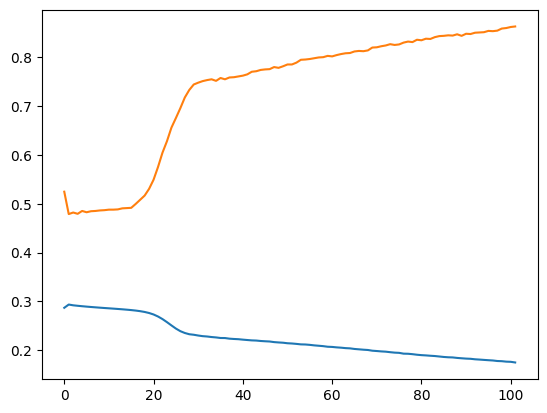

In [19]:
from matplotlib import pyplot as plt
plt.plot(tmp_log)
plt.plot(tmp__log)
plt.show()

In [ ]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
print(input.shape, target.shape)
print(input)
print(target)
output = loss(input, target)
print(output.item())

torch.Size([3, 5]) torch.Size([3, 5])
tensor([[ 0.5443,  0.3086,  0.7909,  0.6841,  0.5280],
        [-2.2931,  0.9872, -0.0502, -0.1197,  0.3200],
        [ 1.1290,  1.6344, -1.9714,  0.4158,  1.1178]], requires_grad=True)
tensor([[0.6052, 0.0118, 0.0234, 0.2101, 0.1495],
        [0.1090, 0.4449, 0.0584, 0.1606, 0.2271],
        [0.0216, 0.3409, 0.1344, 0.3297, 0.1734]])
1.694624423980713
